In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../src') 
from ML_data_cleaning_pipeline import preprocess_df_for_ml

In [2]:
df_raw = pd.read_csv('../data/processed/footpath_phase1.csv')

X, pipeline = preprocess_df_for_ml(df_raw)
y_log = np.log1p(df_raw['duration_hours'])

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, 
    y_log, 
    test_size=0.25,
    random_state=42
)


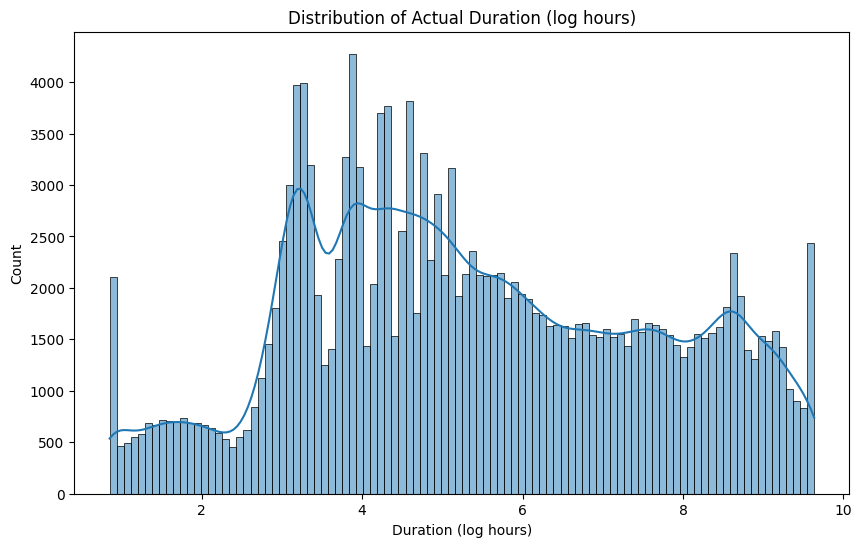

In [3]:
plt.figure(figsize=(10,6))
sns.histplot(y_log, bins=100, kde=True)
plt.title("Distribution of Actual Duration (log hours)")
plt.xlabel("Duration (log hours)")
plt.ylabel("Count")
plt.show()

In [4]:
est = LGBMRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [500, 800, 1200],
    'learning_rate': [0.05, 0.1, 0.25],
    'num_leaves': [63, 127],
}

grid = GridSearchCV(est, param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train_log)

print("Best params:", grid.best_params_)
best = grid.best_estimator_

y_pred_log = best.predict(X_test)

y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8613
[LightGBM] [Info] Number of data points in the train set: 129698, number of used features: 223
[LightGBM] [Info] Start training from score 5.397917
Best params: {'learning_rate': 0.1, 'n_estimators': 1200, 'num_leaves': 127}


In [5]:
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 1242.0392950834594
MSE: 7904493.650013806
RMSE: 2811.4931353310835


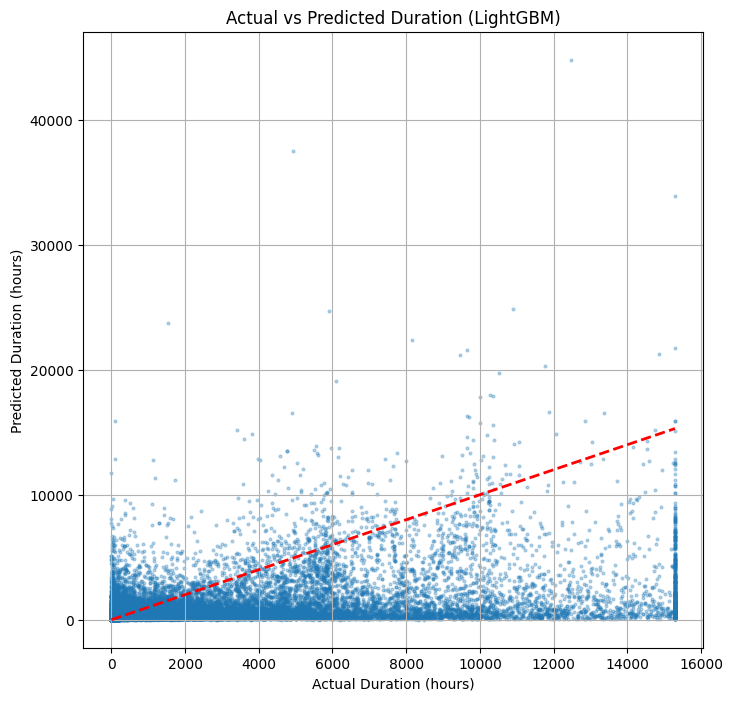

In [6]:
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, alpha=0.3, s=4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)

plt.xlabel("Actual Duration (hours)")
plt.ylabel("Predicted Duration (hours)")
plt.title("Actual vs Predicted Duration (LightGBM)")
plt.grid(True)
plt.show()


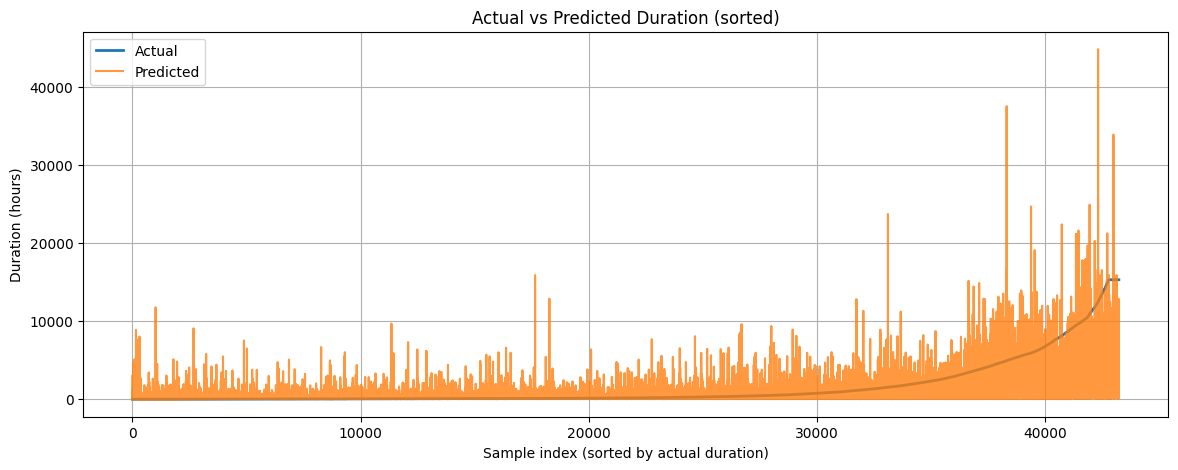

In [7]:
order = np.argsort(y_test.values)

plt.figure(figsize=(14,5))
plt.plot(y_test.values[order], label="Actual", linewidth=2)
plt.plot(y_pred[order], label="Predicted", alpha=0.8)
plt.legend()
plt.xlabel("Sample index (sorted by actual duration)")
plt.ylabel("Duration (hours)")
plt.title("Actual vs Predicted Duration (sorted)")
plt.grid(True)
plt.show()


In [8]:
importances = best.feature_importances_

feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

feat_imp.head(30)


,feature,importance
61,lat,19950
60,lon,19150
2,day,15517
4,hour,12920
1,month,10892
3,weekday,8183
38,tfidf__ถนน,5504
0,year,4981
48,tfidf__รถ,2986
54,tfidf__หลุม,2607
